In [61]:
import duckdb
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, DoubleType, BooleanType, TimestampType
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Quan sát và phân tích Dim Companies

In [58]:
spark = SparkSession.builder.appName("Companies").getOrCreate()

In [59]:
# Connect to the DuckDB database
duck_conn = duckdb.connect('/home/anhcu/Final_ETL_App/etl-app/datawarehouse.duckdb')
query = 'SELECT * FROM dim_companies'

# Fetch data from DuckDB and convert to Pandas DataFrame
pandas_df = duck_conn.execute(query).fetchdf()

duck_conn.close()

In [60]:
# Convert Pandas DataFrame to PySpark DataFrame
spark_df_companies = spark.createDataFrame(pandas_df)

print(spark_df_companies.count())

# Show the Spark DataFrame
spark_df_companies.show()

24/06/22 09:34:46 WARN TaskSetManager: Stage 131 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.
24/06/22 09:34:47 WARN TaskSetManager: Stage 134 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


19697
+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+--------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|company_id|        company_name|  company_time_stamp|company_ticket|company_is_delisted|    company_category|company_currency|    company_location|company_exchange_name|company_region_name|company_industry_name|company_industry_sector|company_sic_industry|  company_sic_sector|
+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+--------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|         1|ADMIRALTY BANCORP...|2024-06-22 07:57:...|          AAAB|               true|Domestic Common S...|             USD|      Florida; U.S.A|         

In [62]:
# Tạo Window specification
windowSpec = Window.partitionBy("company_ticket").orderBy(spark_df_companies["company_time_stamp"].desc())

# Sử dụng row_number để đánh số thứ tự và giữ lại hàng cuối cùng
df_with_row_num = spark_df_companies.withColumn("row_num", F.row_number().over(windowSpec))

# Lọc để giữ lại hàng cuối cùng trong mỗi nhóm
spark_df_companies_filtered = df_with_row_num.filter(df_with_row_num.row_num == 1).drop("row_num")

# Hiển thị DataFrame kết quả
print(spark_df_companies_filtered.count())
spark_df_companies_filtered.show()

24/06/22 09:36:07 WARN TaskSetManager: Stage 135 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


19697


24/06/22 09:36:09 WARN TaskSetManager: Stage 141 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+--------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|company_id|        company_name|  company_time_stamp|company_ticket|company_is_delisted|    company_category|company_currency|    company_location|company_exchange_name|company_region_name|company_industry_name|company_industry_sector|company_sic_industry|  company_sic_sector|
+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+--------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|     13152|          ALCOA CORP|2024-06-22 07:57:...|            AA|              false|Domestic Common S...|             USD| Pennsylvania; U.S.A|               

In [63]:
# Thống kê số lượng công ty ở từng sàn giao dịch
print("Thống kê số lượng công ty ở từng sàn giao dịch:")
spark_df_companies_filtered\
    .groupBy("company_exchange_name")\
    .agg(F.count("*").alias("count"))\
    .withColumnRenamed("company_exchange_name", "Sàn giao dịch")\
    .withColumnRenamed("count", "Số lượng mã niêm yết")\
    .show()

Thống kê số lượng công ty ở từng sàn giao dịch:


24/06/22 09:36:17 WARN TaskSetManager: Stage 144 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+-------------+--------------------+
|Sàn giao dịch|Số lượng mã niêm yết|
+-------------+--------------------+
|         NYSE|                6549|
|       NASDAQ|               13148|
+-------------+--------------------+



In [64]:
# Thống kê số lượng công ty đã và chưa bị delisted
print("Thống kê số lượng công ty bị hủy niêm yết:")
spark_df_companies_filtered\
    .groupBy("company_is_delisted")\
    .agg(F.count("*").alias("count"))\
    .withColumnRenamed("company_is_delisted", "Đã bị hủy niêm yết")\
    .withColumnRenamed("count", "Số lượng")\
    .show()

Thống kê số lượng công ty bị hủy niêm yết:


24/06/22 09:36:24 WARN TaskSetManager: Stage 150 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+------------------+--------+
|Đã bị hủy niêm yết|Số lượng|
+------------------+--------+
|              true|   13181|
|             false|    6516|
+------------------+--------+



In [65]:
# Thống kê số lượng công ty theo quốc gia
print("Thống kê số lượng công ty theo quốc gia:")
spark_df_companies_filtered\
    .withColumn("Quóc gia", F.element_at(F.split(spark_df_companies_filtered["company_location"], "; "), -1))\
    .drop("company_location")\
    .groupBy("Quóc gia")\
    .agg(F.count("*").alias("count"))\
    .orderBy(F.col("count").desc())\
    .withColumnRenamed("count", "Số lượng công ty")\
    .show()

Thống kê số lượng công ty theo quốc gia:


24/06/22 09:36:39 WARN TaskSetManager: Stage 156 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+--------------+----------------+
|      Quóc gia|Số lượng công ty|
+--------------+----------------+
|         U.S.A|           16542|
|        Canada|             531|
|         China|             523|
|United Kingdom|             273|
|        Israel|             226|
|       Bermuda|             179|
|Cayman Islands|             178|
|     Hong Kong|              97|
|     Singapore|              90|
|       Ireland|              79|
|        Brazil|              75|
|   Netherlands|              60|
|     Australia|              57|
|       Germany|              56|
|    Luxembourg|              51|
|   Switzerland|              45|
|        Mexico|              44|
|         Japan|              44|
|        Greece|              43|
|        France|              41|
+--------------+----------------+
only showing top 20 rows



In [66]:
# Thống kê số lượng công ty theo ngành công nghiệp
print("Thống kê số lượng công ty theo ngành công nghiệp:")
spark_df_companies_filtered\
    .groupBy("company_industry_sector")\
    .agg(F.count("*").alias("count"))\
    .orderBy(F.col("count").desc())\
    .withColumnRenamed("company_industry_sector", "Industry")\
    .withColumnRenamed("count", "Số lượng công ty")\
    .show()

Thống kê số lượng công ty theo ngành công nghiệp:


24/06/22 09:37:00 WARN TaskSetManager: Stage 162 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+
|            Industry|Số lượng công ty|
+--------------------+----------------+
|         Industrials|            3687|
|          Technology|            3391|
|          Healthcare|            2989|
|  Financial Services|            2887|
|   Consumer Cyclical|            1900|
|Communication Ser...|            1116|
|         Real Estate|             985|
|              Energy|             844|
|     Basic Materials|             817|
|  Consumer Defensive|             714|
|           Utilities|             367|
+--------------------+----------------+



In [67]:
# Thống kê số lượng công ty theo ngành công nghiệp SIC
print("Thống kê số lượng công ty theo ngành công nghiệp SIC:")
spark_df_companies_filtered\
    .groupBy("company_sic_sector")\
    .agg(F.count("*").alias("count"))\
    .orderBy(F.col("count").desc())\
    .withColumnRenamed("company_sic_sector", "SIC Industry")\
    .withColumnRenamed("count", "Số lượng công ty")\
    .show()

Thống kê số lượng công ty theo ngành công nghiệp SIC:


24/06/22 09:37:11 WARN TaskSetManager: Stage 168 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+
|        SIC Industry|Số lượng công ty|
+--------------------+----------------+
|       Manufacturing|            6394|
|Finance Insurance...|            5722|
|            Services|            3762|
|Transportation Co...|            1597|
|        Retail Trade|             869|
|              Mining|             705|
|     Wholesale Trade|             418|
|        Construction|             160|
|Agriculture Fores...|              70|
+--------------------+----------------+



In [68]:
# Thống kê số lượng công ty theo loại hình công ty
print("Thống kê số lượng công ty theo loại hình công ty:")
spark_df_companies_filtered\
    .groupBy("company_category")\
    .agg(F.count("*").alias("count"))\
    .orderBy(F.col("count").desc())\
    .withColumnRenamed("company_category", "Category")\
    .withColumnRenamed("count", "Số lượng công ty")\
    .show()

Thống kê số lượng công ty theo loại hình công ty:


24/06/22 09:37:22 WARN TaskSetManager: Stage 174 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------------+
|            Category|Số lượng công ty|
+--------------------+----------------+
|Domestic Common S...|           12180|
|Domestic Common S...|            1809|
|    ADR Common Stock|            1482|
|Domestic Common S...|            1296|
|Domestic Common S...|            1028|
|Domestic Preferre...|            1025|
|Canadian Common S...|             247|
|ADR Common Stock ...|             221|
|ADR Common Stock ...|             179|
|ADR Common Stock ...|             122|
| ADR Preferred Stock|              89|
|Canadian Common S...|              10|
|Canadian Common S...|               4|
|Canadian Preferre...|               3|
|Canadian Common S...|               2|
+--------------------+----------------+



## 2. Quan sát và phân tích Fact Candles

In [69]:
# Connect to the DuckDB database
duck_conn = duckdb.connect('/home/anhcu/Final_ETL_App/etl-app/datawarehouse.duckdb')
query = 'SELECT * FROM fact_candles'

# Fetch data from DuckDB and convert to Pandas DataFrame
pandas_df = duck_conn.execute(query).fetchdf()

duck_conn.close()

In [70]:
pandas_df

,candle_id,candle_company_id,candle_volume,candle_volume_weighted,candle_open,candle_close,candle_high,candle_low,candle_time_stamp,candle_num_of_trades,candle_is_otc,candles_time_id
0,1,5,2720,11.4063,11.3700,11.4000,11.450,11.3700,1718136000000,33,NaN,1
1,2,7,129357,1.7232,1.7200,1.7300,1.740,1.7000,1718136000000,806,NaN,1
2,3,9,33671,0.3436,0.3525,0.3524,0.358,0.3200,1718136000000,180,NaN,1
3,4,13,25343916,11.3268,11.4100,11.2800,11.450,11.2600,1718136000000,72704,NaN,1
4,5,14,1531,1.8192,1.8200,1.8340,1.834,1.8001,1718136000000,46,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
48749,48750,19688,267774,11.8107,11.7900,11.8500,11.910,11.7350,1719000000000,2793,NaN,11
48750,48751,19690,224813,2.8716,2.8500,2.8500,2.940,2.8109,1719000000000,1975,NaN,11
48751,48752,19691,209760,21.5625,21.8300,21.1600,22.110,21.1500,1719000000000,2341,NaN,11
48752,48753,19692,155437,3.7196,3.7600,3.7500,3.800,3.6000,1719000000000,588,NaN,11


In [71]:
# Loại bỏ các cột không cần thiết
pandas_df.drop(columns=['candles_time_id'], inplace=True)

# Chuyển đổi kiểu dữ liệu
pandas_df['candle_is_otc'] = pandas_df['candle_is_otc'].fillna(False).astype(bool)
pandas_df['candle_time_stamp'] = pd.to_datetime(pandas_df['candle_time_stamp'], unit='ms')

pandas_df

/tmp/ipykernel_403647/1880719106.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  pandas_df['candle_time_stamp'] = pd.to_datetime(pandas_df['candle_time_stamp'], unit='ms')


,candle_id,candle_company_id,candle_volume,candle_volume_weighted,candle_open,candle_close,candle_high,candle_low,candle_time_stamp,candle_num_of_trades,candle_is_otc
0,1,5,2720,11.4063,11.3700,11.4000,11.450,11.3700,2024-06-11 19:59:07.264,33,False
1,2,7,129357,1.7232,1.7200,1.7300,1.740,1.7000,2024-06-11 19:59:07.264,806,False
2,3,9,33671,0.3436,0.3525,0.3524,0.358,0.3200,2024-06-11 19:59:07.264,180,False
3,4,13,25343916,11.3268,11.4100,11.2800,11.450,11.2600,2024-06-11 19:59:07.264,72704,False
4,5,14,1531,1.8192,1.8200,1.8340,1.834,1.8001,2024-06-11 19:59:07.264,46,False
...,...,...,...,...,...,...,...,...,...,...,...
48749,48750,19688,267774,11.8107,11.7900,11.8500,11.910,11.7350,2024-06-21 19:59:33.888,2793,False
48750,48751,19690,224813,2.8716,2.8500,2.8500,2.940,2.8109,2024-06-21 19:59:33.888,1975,False
48751,48752,19691,209760,21.5625,21.8300,21.1600,22.110,21.1500,2024-06-21 19:59:33.888,2341,False
48752,48753,19692,155437,3.7196,3.7600,3.7500,3.800,3.6000,2024-06-21 19:59:33.888,588,False


In [72]:
# Xác định schema
schema = StructType([
    StructField("candle_id", IntegerType(), True),
    StructField("candle_company_id", IntegerType(), True),
    StructField("candle_volume", LongType(), True),
    StructField("candle_volume_weighted", DoubleType(), True),
    StructField("candle_open", DoubleType(), True),
    StructField("candle_close", DoubleType(), True),
    StructField("candle_high", DoubleType(), True),
    StructField("candle_low", DoubleType(), True),
    StructField("candle_time_stamp", TimestampType(), True),
    StructField("candle_num_of_trades", IntegerType(), True),
    StructField("candle_is_otc", BooleanType(), True)
])

# Chuyển đổi Pandas DataFrame thành PySpark DataFrame với schema
spark_df_candles = spark.createDataFrame(pandas_df, schema=schema)

# Hiển thị một vài hàng của DataFrame
print(spark_df_candles.count())
spark_df_candles.show()

24/06/22 09:37:47 WARN TaskSetManager: Stage 180 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.


48754
+---------+-----------------+-------------+----------------------+-----------+------------+-----------+----------+--------------------+--------------------+-------------+
|candle_id|candle_company_id|candle_volume|candle_volume_weighted|candle_open|candle_close|candle_high|candle_low|   candle_time_stamp|candle_num_of_trades|candle_is_otc|
+---------+-----------------+-------------+----------------------+-----------+------------+-----------+----------+--------------------+--------------------+-------------+
|        1|                5|         2720|               11.4063|      11.37|        11.4|      11.45|     11.37|2024-06-11 19:59:...|                  33|        false|
|        2|                7|       129357|                1.7232|       1.72|        1.73|       1.74|       1.7|2024-06-11 19:59:...|                 806|        false|
|        3|                9|        33671|                0.3436|     0.3525|      0.3524|      0.358|      0.32|2024-06-11 19:59:...|    

24/06/22 09:37:47 WARN TaskSetManager: Stage 183 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.


In [73]:
# Thống kê khối lượng cổ phiếu được giao dịch trong ngày
print("Thống kê khối lượng cổ phiếu được giao dịch trong ngày:")
spark_df_candles\
    .withColumn("Ngày giao dịch", F.to_date(F.col("candle_time_stamp")))\
    .groupBy("Ngày giao dịch")\
    .agg(
        F.sum("candle_volume").alias("Tổng khối lượng cổ phiếu được giao dịch trong ngày"),
        F.sum("candle_num_of_trades").alias("Tổng số giao dịch được thực hiện"),
        F.sum(F.when(F.col("candle_is_otc") == True, 1).otherwise(0)).alias("Số lượng mã OTC")
    )\
    .orderBy(F.col("Ngày giao dịch"))\
    .show()

Thống kê khối lượng cổ phiếu được giao dịch trong ngày:


24/06/22 09:38:13 WARN TaskSetManager: Stage 184 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.


+--------------+--------------------------------------------------+--------------------------------+---------------+
|Ngày giao dịch|Tổng khối lượng cổ phiếu được giao dịch trong ngày|Tổng số giao dịch được thực hiện|Số lượng mã OTC|
+--------------+--------------------------------------------------+--------------------------------+---------------+
|    2024-06-11|                                        8249417549|                        62443178|            340|
|    2024-06-12|                                        9194939538|                        72183673|            366|
|    2024-06-13|                                        8152242295|                        62190290|            355|
|    2024-06-14|                                        8057326926|                        60749531|            360|
|    2024-06-17|                                        9225782095|                        65865260|            370|
|    2024-06-18|                                        93010231

In [ ]:
# Thống kê khối lượng cổ phiếu được giao dịch trong ngày
print("Thống kê khối lượng cổ phiếu được giao dịch trong ngày:")
result_df = spark_df_candles\
    .withColumn("Ngày giao dịch", F.to_date(F.col("candle_time_stamp")))\
    .groupBy("Ngày giao dịch")\
    .agg(
        F.sum("candle_volume").alias("Tổng khối lượng cổ phiếu được giao dịch trong ngày"),
        F.sum("candle_num_of_trades").alias("Tổng số giao dịch được thực hiện"),
        F.sum(F.when(F.col("candle_is_otc") == True, 1).otherwise(0)).alias("Số lượng mã OTC")
    )\
    .orderBy(F.col("Ngày giao dịch"))\
    .toPandas()
    
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(result_df["Khung giờ"], result_df["Tổng số bài báo được phát hành"], color='skyblue')
plt.xlabel('Khung giờ')
plt.ylabel('Tổng số bài báo được phát hành')
plt.title('Số lượng bài báo theo các khung giờ')
plt.xticks(result_df["Khung giờ"])  # Đảm bảo tất cả các khung giờ được hiển thị
plt.grid(axis='y')

# Hiển thị biểu đồ
plt.show()


Thống kê khối lượng cổ phiếu được giao dịch trong ngày:


24/06/22 09:42:38 WARN TaskSetManager: Stage 203 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.


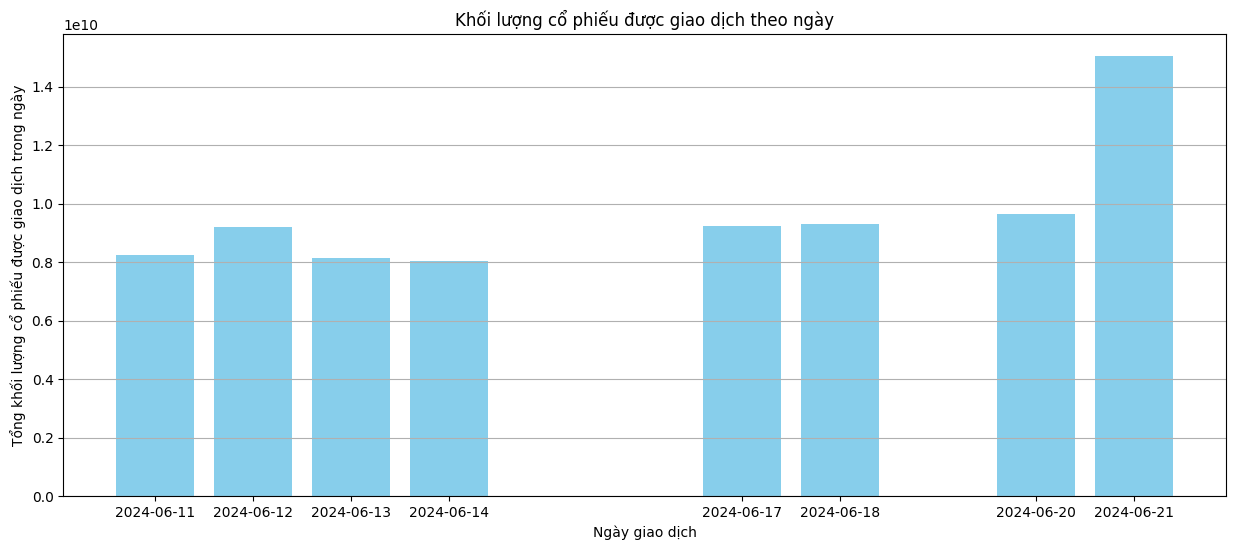

In [76]:
# Thống kê khối lượng cổ phiếu được giao dịch trong ngày
print("Thống kê khối lượng cổ phiếu được giao dịch trong ngày:")
result_df = spark_df_candles\
    .withColumn("Ngày giao dịch", F.to_date(F.col("candle_time_stamp")))\
    .groupBy("Ngày giao dịch")\
    .agg(F.sum("candle_volume").alias("Tổng khối lượng cổ phiếu được giao dịch trong ngày"))\
    .orderBy(F.col("Ngày giao dịch"))\
    .toPandas()
    
# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.bar(result_df["Ngày giao dịch"], result_df["Tổng khối lượng cổ phiếu được giao dịch trong ngày"], color='skyblue')
plt.xlabel('Ngày giao dịch')
plt.ylabel('Tổng khối lượng cổ phiếu được giao dịch trong ngày')
plt.title('Khối lượng cổ phiếu được giao dịch theo ngày')
plt.xticks(result_df["Ngày giao dịch"])  # Đảm bảo tất cả các khung giờ được hiển thị
plt.grid(axis='y')

# Hiển thị biểu đồ
plt.show()

Thống kê khối lượng cổ phiếu được giao dịch trong ngày:


24/06/22 09:44:14 WARN TaskSetManager: Stage 219 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.


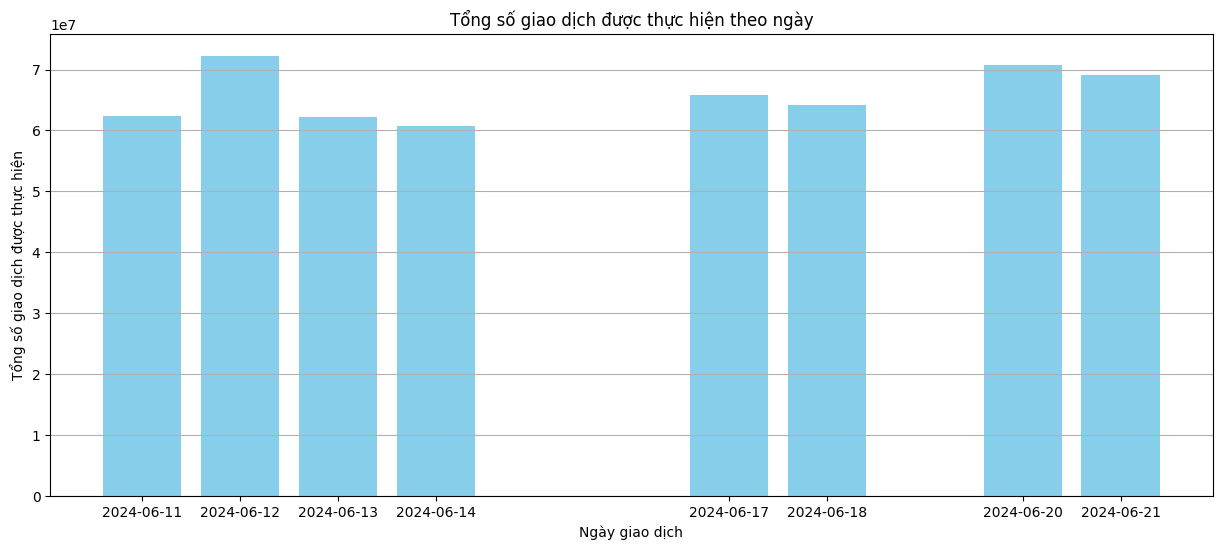

In [78]:
# Thống kê khối lượng cổ phiếu được giao dịch trong ngày
print("Thống kê khối lượng cổ phiếu được giao dịch trong ngày:")
result_df = spark_df_candles\
    .withColumn("Ngày giao dịch", F.to_date(F.col("candle_time_stamp")))\
    .groupBy("Ngày giao dịch")\
    .agg(F.sum("candle_num_of_trades").alias("Tổng số giao dịch được thực hiện"))\
    .orderBy(F.col("Ngày giao dịch"))\
    .toPandas()
    
# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.bar(result_df["Ngày giao dịch"], result_df["Tổng số giao dịch được thực hiện"], color='skyblue')
plt.xlabel('Ngày giao dịch')
plt.ylabel('Tổng số giao dịch được thực hiện')
plt.title('Tổng số giao dịch được thực hiện theo ngày')
plt.xticks(result_df["Ngày giao dịch"])  # Đảm bảo tất cả các khung giờ được hiển thị
plt.grid(axis='y')

# Hiển thị biểu đồ
plt.show()

## 3. Phân tích kết hợp Dim Companies và Fact Candles

In [79]:
# Kết hợp hai bảng dựa trên company_id và candle_company_id
joined_df = spark_df_candles.join(spark_df_companies_filtered, spark_df_candles.candle_company_id == spark_df_companies_filtered.company_id)

# Hiển thị một vài hàng của DataFrame kết hợp
joined_df.show()

24/06/22 09:44:36 WARN TaskSetManager: Stage 227 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.
24/06/22 09:44:37 WARN TaskSetManager: Stage 228 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----------------+-------------+----------------------+-----------+------------+-----------+----------+--------------------+--------------------+-------------+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+-------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|candle_id|candle_company_id|candle_volume|candle_volume_weighted|candle_open|candle_close|candle_high|candle_low|   candle_time_stamp|candle_num_of_trades|candle_is_otc|company_id|        company_name|  company_time_stamp|company_ticket|company_is_delisted|    company_category|company_currency|   company_location|company_exchange_name|company_region_name|company_industry_name|company_industry_sector|company_sic_industry|  company_sic_sector|
+---------+-----------------+-------------+----------------------+-----------+------------+-----------+---

In [80]:
# Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp
print('Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp')
joined_df\
    .groupBy("company_industry_sector")\
    .agg(round(F.avg("candle_volume")).alias("Khối lượng trung bình"))\
    .orderBy("Khối lượng trung bình", ascending=False)\
    .withColumnRenamed("company_industry_sector", "Ngành")\
    .show()
    
# Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp SIC
print('Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp SIC')
joined_df\
    .groupBy("company_sic_sector")\
    .agg(round(F.avg("candle_volume")).alias("Khối lượng trung bình"))\
    .orderBy("Khối lượng trung bình", ascending=False)\
    .withColumnRenamed("company_sic_sector", "Ngành SIC")\
    .show()

Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp


24/06/22 09:44:45 WARN TaskSetManager: Stage 233 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.
24/06/22 09:44:45 WARN TaskSetManager: Stage 234 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+---------------------+
|               Ngành|Khối lượng trung bình|
+--------------------+---------------------+
|          Technology|            2357104.0|
|   Consumer Cyclical|            2117580.0|
|              Energy|            2038546.0|
|Communication Ser...|            1994757.0|
|     Basic Materials|            1860275.0|
|  Consumer Defensive|            1506694.0|
|           Utilities|            1444863.0|
|  Financial Services|            1293505.0|
|          Healthcare|            1224835.0|
|         Industrials|            1076719.0|
|         Real Estate|            1075370.0|
+--------------------+---------------------+

Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp SIC


24/06/22 09:44:48 WARN TaskSetManager: Stage 242 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.
24/06/22 09:44:48 WARN TaskSetManager: Stage 243 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+---------------------+
|           Ngành SIC|Khối lượng trung bình|
+--------------------+---------------------+
|              Mining|            2272506.0|
|Transportation Co...|            1897383.0|
|       Manufacturing|            1892532.0|
|        Retail Trade|            1855506.0|
|            Services|            1595140.0|
|Finance Insurance...|             874855.0|
|     Wholesale Trade|             771310.0|
|        Construction|             542432.0|
|Agriculture Fores...|             376812.0|
+--------------------+---------------------+



In [81]:
# Top 10 công ty có tổng khối lượng giao dịch nhiều nhất hiện tại
print('Top 10 công ty có tổng khối lượng giao dịch nhiều nhất hiện tại')
joined_df\
    .groupBy("company_name")\
    .agg(
        F.sum("candle_volume").alias("Tổng khối lượng cổ phiếu được giao dịch"),
        F.sum("candle_num_of_trades").alias("Tổng số giao dịch được thực hiện")
    )\
    .orderBy("Tổng khối lượng cổ phiếu được giao dịch", ascending=False)\
    .withColumnRenamed("company_name", "Tên công ty")\
    .limit(10)\
    .show()

Top 10 công ty có tổng khối lượng giao dịch nhiều nhất hiện tại


24/06/22 09:45:02 WARN TaskSetManager: Stage 251 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.
24/06/22 09:45:02 WARN TaskSetManager: Stage 252 contains a task of very large size (2180 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+---------------------------------------+--------------------------------+
|         Tên công ty|Tổng khối lượng cổ phiếu được giao dịch|Tổng số giao dịch được thực hiện|
+--------------------+---------------------------------------+--------------------------------+
|         NVIDIA CORP|                             2722871456|                        19416525|
|     MUSTANG BIO INC|                             1539050511|                         1684866|
|           APPLE INC|                              991837432|                         9131056|
|CROWN ELECTROKINE...|                              930850458|                          469880|
|NAUTICUS ROBOTICS...|                              909287893|                          903853|
|         NIKOLA CORP|                              790993184|                          742318|
|       GAMESTOP CORP|                              677424745|                         5170282|
|           TESLA INC|                  

## 4. Quan sát và phân tích Dim News

In [82]:
# Connect to the DuckDB database
duck_conn = duckdb.connect('/home/anhcu/Final_ETL_App/etl-app/datawarehouse.duckdb')
query = 'SELECT * FROM dim_news'

# Fetch data from DuckDB and convert to Pandas DataFrame
pandas_df = duck_conn.execute(query).fetchdf()

duck_conn.close()

In [83]:
# Loại bỏ các cột không cần thiết
pandas_df.drop(columns=['new_title', 'new_url', 'new_authors', 'new_summary', 'news_time_id'], inplace=True)

# Chuyển đổi kiểu dữ liệu
pandas_df['new_time_published'] = pd.to_datetime(pandas_df['new_time_published'], format='%Y%m%dT%H%M%S')

pandas_df

,new_id,new_time_published,new_source,new_overall_sentiment_score,new_overall_sentiment_label
0,1,2024-06-11 23:58:00,CNN,-0.075916,Neutral
1,2,2024-06-11 23:49:00,GlobeNewswire,0.361400,Bullish
2,3,2024-06-11 23:45:00,The Financial Express,-0.002397,Neutral
3,4,2024-06-11 23:41:39,Benzinga,0.061695,Neutral
4,5,2024-06-11 23:41:00,CNN,-0.007297,Neutral
...,...,...,...,...,...
10651,10652,2024-06-21 13:00:11,Zacks Commentary,0.202436,Somewhat-Bullish
10652,10653,2024-06-21 13:00:11,Zacks Commentary,0.222067,Somewhat-Bullish
10653,10654,2024-06-21 13:00:10,Zacks Commentary,0.255022,Somewhat-Bullish
10654,10655,2024-06-21 13:00:10,Zacks Commentary,0.229096,Somewhat-Bullish


In [84]:
# Chuyển đổi Pandas DataFrame thành PySpark DataFrame với schema
spark_df_news = spark.createDataFrame(pandas_df)

# Hiển thị một vài hàng của DataFrame
print(spark_df_news.count())
spark_df_news.show()

10656
+------+-------------------+--------------------+---------------------------+---------------------------+
|new_id| new_time_published|          new_source|new_overall_sentiment_score|new_overall_sentiment_label|
+------+-------------------+--------------------+---------------------------+---------------------------+
|     1|2024-06-11 23:58:00|                 CNN|                  -0.075916|                    Neutral|
|     2|2024-06-11 23:49:00|       GlobeNewswire|                     0.3614|                    Bullish|
|     3|2024-06-11 23:45:00|The Financial Exp...|                  -0.002397|                    Neutral|
|     4|2024-06-11 23:41:39|            Benzinga|                   0.061695|                    Neutral|
|     5|2024-06-11 23:41:00|                 CNN|                  -0.007297|                    Neutral|
|     6|2024-06-11 23:41:00|       GlobeNewswire|                    0.02849|                    Neutral|
|     7|2024-06-11 23:39:00|    Associat

In [85]:
# Số lượng bài báo từ các nguồn
print('Số lượng bài báo từ các nguồn')
spark_df_news\
    .groupBy("new_source")\
    .agg(F.count("new_id").alias("Tổng số bài báo được phát hành"))\
    .orderBy("Tổng số bài báo được phát hành", ascending=False)\
    .withColumnRenamed("new_source", "Nguồn")\
    .show()

Số lượng bài báo từ các nguồn


+--------------------+------------------------------+
|               Nguồn|Tổng số bài báo được phát hành|
+--------------------+------------------------------+
|            Benzinga|                          3130|
|    Zacks Commentary|                          1672|
|       GlobeNewswire|                           672|
|              Forbes|                           661|
|    Business Insider|                           633|
|   Business Standard|                           540|
|                 CNN|                           480|
|         PR Newswire|                           377|
|         Motley Fool|                           360|
|    Associated Press|                           320|
|       Stocknews.com|                           300|
|     Canada Newswire|                           258|
|       Cointelegraph|                           185|
|                CNBC|                           161|
|The Financial Exp...|                           133|
|          Decrypt.co|      

Số lượng bài báo thoe các khung giờ


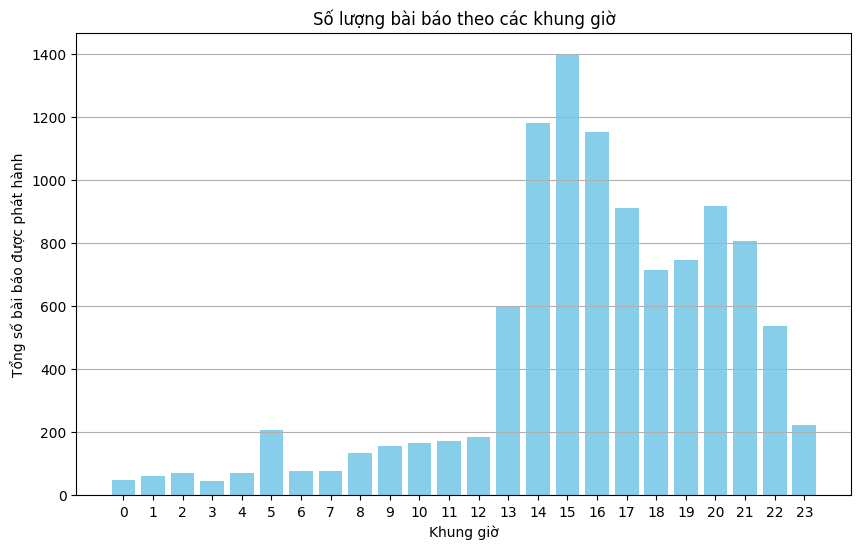

In [87]:
# Số lượng bài báo thoe các khung giờ
print('Số lượng bài báo thoe các khung giờ')
result_df = spark_df_news\
    .withColumn("hour", F.hour("new_time_published"))\
    .groupBy("hour")\
    .agg(F.count("new_id").alias("Tổng số bài báo được phát hành"))\
    .withColumnRenamed("hour", "Khung giờ")\
    .orderBy("Khung giờ")\
    .toPandas()
    
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(result_df["Khung giờ"], result_df["Tổng số bài báo được phát hành"], color='skyblue')
plt.xlabel('Khung giờ')
plt.ylabel('Tổng số bài báo được phát hành')
plt.title('Số lượng bài báo theo các khung giờ')
plt.xticks(result_df["Khung giờ"])  # Đảm bảo tất cả các khung giờ được hiển thị
plt.grid(axis='y')

# Hiển thị biểu đồ
plt.show()